In [32]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import SKLearn Compose Modules
from sklearn.compose import (
    make_column_selector,
    make_column_transformer,
    ColumnTransformer,
    TransformedTargetRegressor
)

# Import SKLearn Preprocessing Modules
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder
)

# Import SKLearn Linear Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

# Import SKLearn Feature Selection
from sklearn.feature_selection import SelectFromModel

# Import SKLearn Pipeline
from sklearn.pipeline import Pipeline

# Import SKLearn Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Import SKLearn Metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    mean_squared_error,
    r2_score
)

# Import SKLearn KNN Models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Import SKLearn SVM Model
from sklearn.svm import SVC

# Import SKLearn Tree Model
from sklearn.tree import DecisionTreeClassifier

# Import SKLearn Ensemble Models
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier, 
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor
)

# Import SKLearn Dummy
from sklearn.dummy import DummyClassifier, DummyRegressor

### Problem Statement

Power information has not been centrally collected and managed and therefore many products have no data.  The goal is to develop a model to estimate typical power for our products where data is unavailable: There will be 3 parts to this project:
    1. Using unsupervised learning, group like products together based on BOM information and other categorical data.
    2. Based on the groupings and available data, use a supervised learning module to estimate product weight, as it’s related to product power.
    3. Predict the weight for products with no data. Use this completed data set to create a new supervised learning module to estimate the power for products with no power data.


### Importance

The energy my companies products consume is its largest source of greenhouse gas emissions. By better estimating the power from the products with no data we can more accurately estimate the annual total emissions from the sale of our products.


### Load in initial file with labeled and unlabeled data

In [2]:
# Data source: internal systems

df = pd.read_csv('20250714_MASTER_DATA.csv')
df1 = df

# Manually labeled data that was incorrectly classified
re = pd.read_csv('20250714_reinforcement.csv')

In [3]:
# Combine re and df1 data where re superceeds df1 data
required_cols = {'TOP_PID', 'MECH_COMP', 'MOD_COMP'}
missing_cols = required_cols - set(re.columns)
if missing_cols:
    raise KeyError(f"The following required columns are missing in 're': {missing_cols}")

# Step 1: Merge re into df on TOP_PID
merged = df1.merge(
    re[['TOP_PID', 'MECH_COMP', 'MOD_COMP']],
    on='TOP_PID',
    how='left',
    suffixes=('', '_new')
)

# Step 2: Replace only if new value is not null
if 'MECH_COMP_new' in merged.columns:
    df1['MECH_COMP'] = merged['MECH_COMP_new'].combine_first(df1['MECH_COMP'])

if 'MOD_COMP_new' in merged.columns:
    df1['MOD_COMP'] = merged['MOD_COMP_new'].combine_first(df1['MOD_COMP'])

# Step 3: Drop temporary columns if they exist
df1.drop(columns=['MECH_COMP_new', 'MOD_COMP_new'], inplace=True, errors='ignore')

In [4]:
# Count number of columns by data type
column_type_counts = df1.dtypes.value_counts()

print(column_type_counts)
print(df1.shape)

int64      76
object      6
float64     4
Name: count, dtype: int64
(93449, 86)


In [5]:
# Define column groups for clarity and reuse
ic_cols = [
    '01-ASIC Module', '08-ASIC', '15-Logic','15-Communication', '15-Linear', '15-Memory',
    '15-Microprocessor', '15-Multimedia', '15-OptoElectronic', '15-RF', '15-Timing',
    '15-Transducer', '16-Programmable Logic', '16-Programmable Memory', '17-Programmed Device'
]

elec_cols = [
    '11-Capacitor', '12-Resistor', '13-Diode', '18-Delay Line', '19-Crystal-Oscillator-SAW Oscillator',
    '20-Transistor', '21-Filter-Circuit Protection', '22-Switch', '23-Relay',
    '24-Transformer-Inductor-Toroid', '25-LED', '26-Socket'
]

pack_cols = [
    '501-Packaging - Foam', '502-Packaging - Bag-Envelope', '503-Packaging - Wood',
    '504-Packaging - OEM Data', '55-Packaging - Corrugated Component'
]

mech_cols = [
    '48-Screw', '49-Nut-Washer', '50-Standoff-Spacer', '51-General Hardware-Gasket', '51-Heatsink',
    '52-Clip-Clamp', '700-Custom Fabricated - Metal-Plastic', '700-Custom Heatsink', '32-Wire Lug'
]

psu_cols = [
    '34-Off the Shelf Power Supply', '341-Custom Power Supply', '36-Ferrite Array'
]

cable_cols = [
    '31-Raw Wire-Raw Cable', '37-Jack-Power Cord', '72-Cable Assembly-Wiring Harness'
]

kit_cols = [
    '69-Mechanical Kit', '53-Accessory Kit'
]

optical_cols = [
    '05-Optical Passive', '10-Optical Active', '66-Pluggable Optic'
]

# Create category totals
df1['IC'] = df[ic_cols].sum(axis=1)
df1['elec'] = df[elec_cols].sum(axis=1)
df1['pack'] = df[pack_cols].sum(axis=1)
df1['mech'] = df[mech_cols].sum(axis=1)
df1['psu'] = df[psu_cols].sum(axis=1)
df1['cable'] = df[cable_cols].sum(axis=1)
df1['kit'] = df[kit_cols].sum(axis=1)
df1['optical'] = df[optical_cols].sum(axis=1)

# Assign 'type' using priority logic
conditions = [
    df['MECH_COMP'] == 'Y',
    df['MOD_COMP'] == 'Y',
    df['TYP_PWR_W'] > 0,
    df['PROD_PWR_W'] > 0
]
choices = ['mech', 'mod', 'pwr','pwr']

df1['type'] = np.select(conditions, choices, default='nan')


# Drop unneeded columns that were combined above

df1 = df1.drop(['300-Liquid Cooling Assy','301-Custom Quick Disconnect Coupling','302-Quick Disconnect Coupling',
               '303-Tubing','304-Pump','305-Coolant', '01-ASIC Module', '08-ASIC', '15-Logic','15-Communication','15-Linear','15-Memory','15-Microprocessor',
               '15-Multimedia','15-OptoElectronic','15-RF','15-Timing','15-Transducer','16-Programmable Logic','16-Programmable Memory',
               '17-Programmed Device','11-Capacitor','12-Resistor','13-Diode','18-Delay Line','19-Crystal-Oscillator-SAW Oscillator',
                 '20-Transistor','21-Filter-Circuit Protection','22-Switch','23-Relay',
                 '24-Transformer-Inductor-Toroid','25-LED','26-Socket','501-Packaging - Foam','502-Packaging - Bag-Envelope','503-Packaging - Wood',
                  '504-Packaging - OEM Data','55-Packaging - Corrugated Component','48-Screw','49-Nut-Washer','50-Standoff-Spacer','51-General Hardware-Gasket','51-Heatsink',
                  '52-Clip-Clamp','700-Custom Fabricated - Metal-Plastic','700-Custom Heatsink','73-Printed Circuit Assembly','800-Assembly-Sub Assembly',
               '800-Heatsink Assembly','84-Packaging Assembly','68-Final Assembl','33-Fan-Blower.1','32-Wire Lug',
               '34-Off the Shelf Power Supply','341-Custom Power Supply','36-Ferrite Array','31-Raw Wire-Raw Cable',
               '37-Jack-Power Cord','72-Cable Assembly-Wiring Harness','69-Mechanical Kit','53-Accessory Kit',
               '05-Optical Passive','10-Optical Active','66-Pluggable Optic','MECH_COMP','MOD_COMP','TYP_PWR_W', 'PROD_PWR_W','POWER_TYPE','PACKAGING_WEIGHT_KG'
                ,'NET_WEIGHT_KG'
              ], axis = 1)

# Summerize total components and create new column

df1['total_comp'] = df1[[
    '06-Audio Equipment', '07-RF Equipment', '28-Printed Circuit Board',
    '29_27-Connector-Header-Terminal', '30-Telecommunications Module', '33-Fan-Blower',
    '35-Battery', '39-Optical Connector-Cable', '43-Video Equipment - Camera-Lens-Image Sensor',
    '43-Video Equipment - Display', '58-Disk Drive', '74-ODM or OEM Assembly',
    'IC', 'elec', 'pack', 'mech', 'psu', 'cable', 'kit', 'optical'
]].sum(axis=1)

# Drop items that have > 1 74- CC and < 200 components

df2 = df1[
    (df1['74-ODM or OEM Assembly'] == 0) |
    ((df1['74-ODM or OEM Assembly'] > 1) & (df1['total_comp'] > 200)) 
]

# Change 'nan' into NaN

df2['type'] = df2['type'].replace(['nan', 'None'], np.nan)
# Drop items that have 0 total compoents

df2 = df2.query('total_comp > 0')

# Split file into labeled (lab) and unlabeled (unlab) data. This is based on type notation.

lab = df2[df2['type'].notna()]   # rows where 'type' is NOT null
unlab = df2[df2['type'].isna()]  # rows where 'type' IS null

/var/folders/s8/46tslbx12qs9ztmh7gmj3nkm0000gn/T/ipykernel_35345/2223799643.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['type'] = df2['type'].replace(['nan', 'None'], np.nan)


In [6]:
# Count number of columns by data type
column_type_counts = df2.dtypes.value_counts()

print(column_type_counts)
print(df2.shape)

int64     21
object     4
Name: count, dtype: int64
(41279, 25)


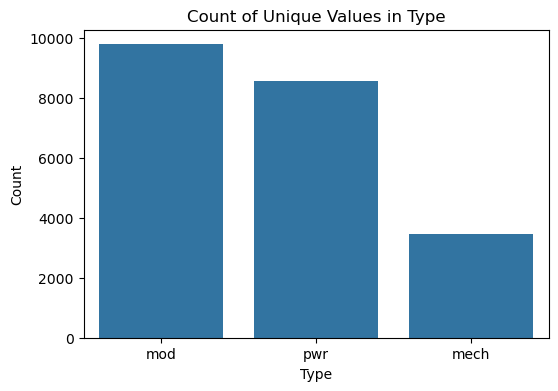

In [7]:
# Get the count of each unique value in the target variable
target_quantity = lab['type'].value_counts(dropna=False)

# Create a bar chart using seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=target_quantity.index, y=target_quantity.values)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of Unique Values in Type')

# Show the plot
plt.show()

In [8]:
# Checking for missing data in labeled data. There is no missing data, all data is either 0 or has a value.

# Count missing per column
missing_count = lab.isnull().sum()

# % missing per column
missing_percent = 100 * lab.isnull().sum() / len(df)

# Combine into one DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
}).sort_values(by="Missing %", ascending=False)

print(missing_summary)

                                               Missing Count  Missing %
TOP_PID                                                    0        0.0
58-Disk Drive                                              0        0.0
type                                                       0        0.0
optical                                                    0        0.0
kit                                                        0        0.0
cable                                                      0        0.0
psu                                                        0        0.0
mech                                                       0        0.0
pack                                                       0        0.0
elec                                                       0        0.0
IC                                                         0        0.0
74-ODM or OEM Assembly                                     0        0.0
43-Video Equipment - Display                               0    

### Check how balanced data is

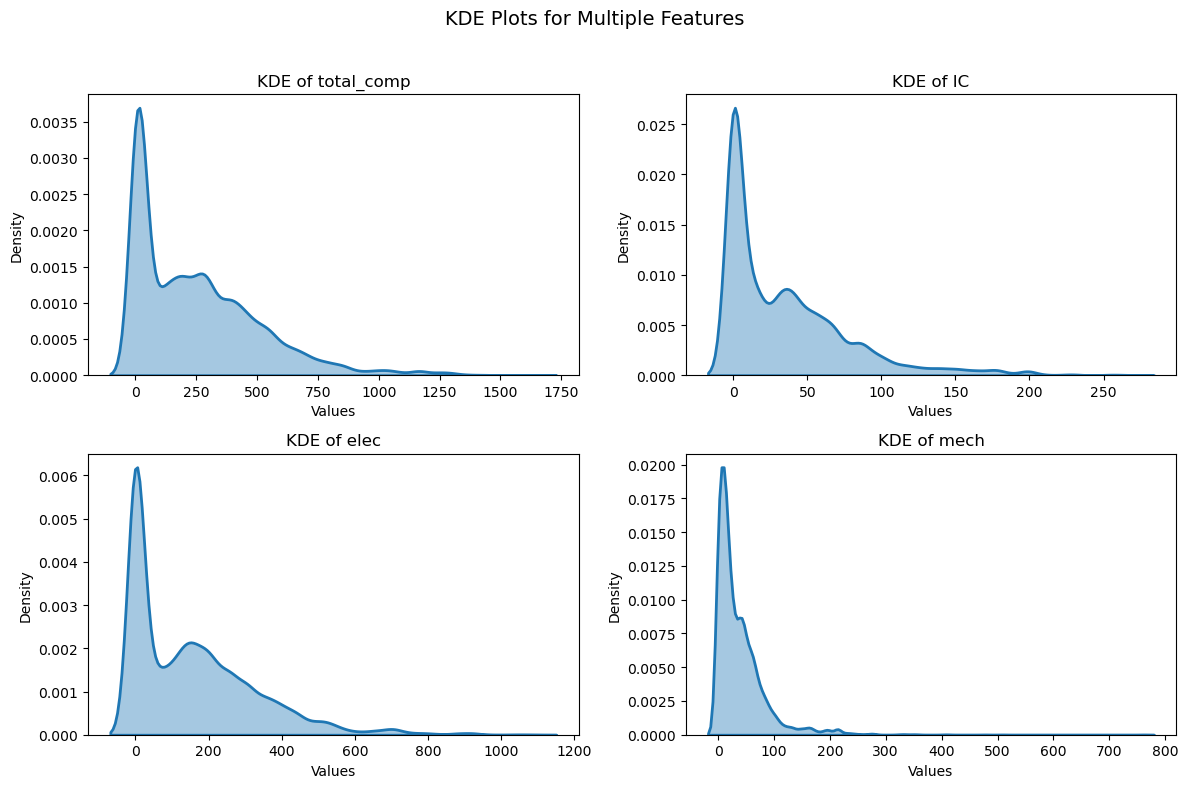

In [9]:
cols = ['total_comp', 'IC', 'elec', 'mech']

# Create 4 subplots (2 rows × 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flat, cols):
    sns.kdeplot(lab[col], fill=True, linewidth=2, alpha=0.4, ax=ax)
    ax.set_title(f"KDE of {col}")
    ax.set_xlabel("Values")
    ax.set_ylabel("Density")

plt.suptitle("KDE Plots for Multiple Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


I selected a few sample features to check to see how skewed the data was. Based on the analysis, there are a lot of products that have smaller values and a longer tail of products with higher values, but fewer of them.

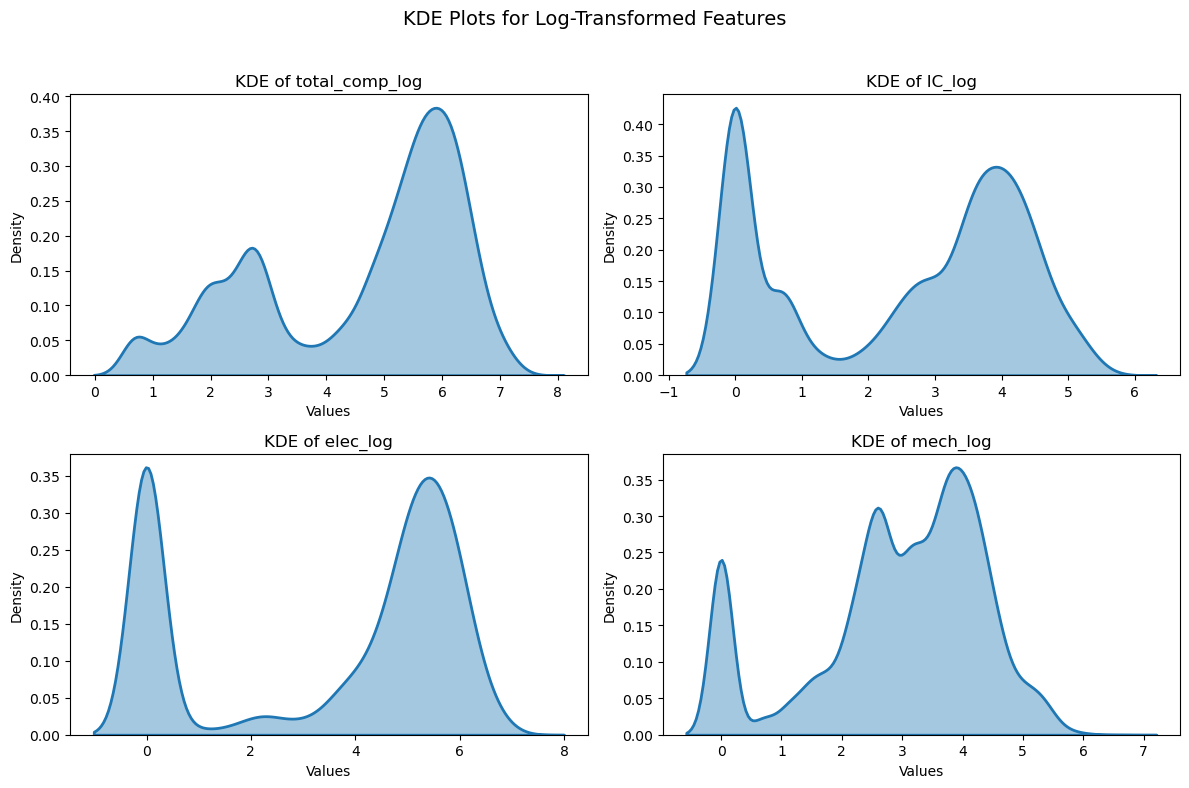

In [10]:
# Apply a log transofrmation to reduce skewness

lab3 = pd.DataFrame()
lab3['IC_log'] = np.log1p(lab['IC'])
lab3['elec_log'] = np.log1p(lab['elec'])
lab3['mech_log'] = np.log1p(lab['mech'])
lab3['total_comp_log'] = np.log1p(lab['total_comp'])

cols = ['total_comp_log', 'IC_log', 'elec_log', 'mech_log']

# Create 4 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flat, cols):
    sns.kdeplot(lab3[col], fill=True, linewidth=2, alpha=0.4, ax=ax)
    ax.set_title(f"KDE of {col}")
    ax.set_xlabel("Values")
    ax.set_ylabel("Density")

plt.suptitle("KDE Plots for Log-Transformed Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

I corrected for the skewness by using a log function which created a more balanced data set which should help with optimizing a model

### Split Data

In [11]:
# Define features X and target y
X = lab.drop(['type' , 'TOP_PID'], axis=1)
y = lab['type']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify  new categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Check Correlation of Data

In [12]:
y_train_series = pd.Series(y_train, index=X_train.index)

# Select only numeric columns
X_num = X_train.select_dtypes(include='number')

# Compute correlation with target
corrs = X_num.corrwith(y_train_series)

# Sort by absolute value
corrs_sorted = corrs.abs().sort_values(ascending=False)
print(corrs_sorted)

29_27-Connector-Header-Terminal                  0.503253
total_comp                                       0.502207
28-Printed Circuit Board                         0.493526
elec                                             0.481114
35-Battery                                       0.441100
IC                                               0.416970
mech                                             0.394333
psu                                              0.393489
33-Fan-Blower                                    0.312806
pack                                             0.305439
cable                                            0.233699
kit                                              0.229556
07-RF Equipment                                  0.229031
43-Video Equipment - Display                     0.125903
06-Audio Equipment                               0.123411
43-Video Equipment - Camera-Lens-Image Sensor    0.084521
39-Optical Connector-Cable                       0.073547
optical       

### Check baseline using dummy classifier

In [13]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline (Most Frequent Class):")
print(classification_report(y_test, y_pred_dummy, target_names=le.classes_))

Baseline (Most Frequent Class):
              precision    recall  f1-score   support

        mech       0.00      0.00      0.00      1031
         mod       0.45      1.00      0.62      2951
         pwr       0.00      0.00      0.00      2572

    accuracy                           0.45      6554
   macro avg       0.15      0.33      0.21      6554
weighted avg       0.20      0.45      0.28      6554



/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mod is the majority class (2951/6554). If Mod was choosen everytime the accuracy would be 45%, therefore any model should perform better than the 45% accuracy and 62% F1-score.

### Determine Best Classification Model and Hyperparameters for Type Identification

In [14]:


# Build ColumnTransformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), categorical_columns)
    ]
)

# Create a dictionary of models and hyperparameter grids for tuning with GridSearchCV

models = {
    'knn': (KNeighborsClassifier(), {
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance']
    }),
    'logisticregression': (LogisticRegression(max_iter=1000, solver='saga'), {
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
        'logisticregression__penalty': ['l1', 'l2']
    }),
    'svc': (SVC(), {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    }),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {
        'decisiontreeclassifier__max_depth': [5, 10, 15],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
        'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
        'decisiontreeclassifier__criterion': ['gini', 'entropy']
    }),  
    'randomforest': (RandomForestClassifier(), {
        'randomforest__n_estimators': [100, 200],
        'randomforest__max_depth': [5, 10, 20],
        'randomforest__min_samples_split': [2, 5],
        'randomforest__min_samples_leaf': [1, 2]
    }),
    'gradientboosting': (GradientBoostingClassifier(), {
        'gradientboosting__n_estimators': [100, 200],
        'gradientboosting__learning_rate': [0.01, 0.1],
        'gradientboosting__max_depth': [3, 5]
    })
}


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

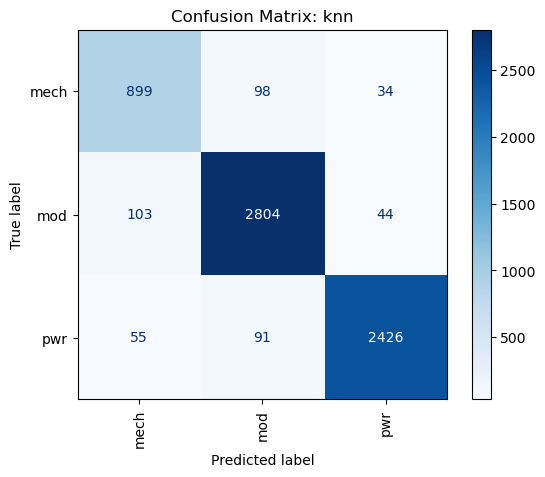

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef

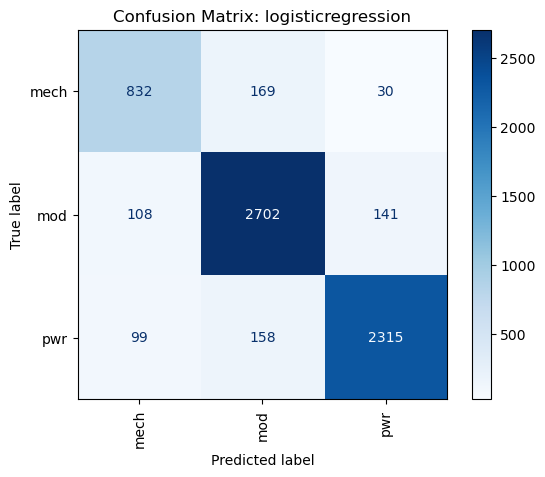

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

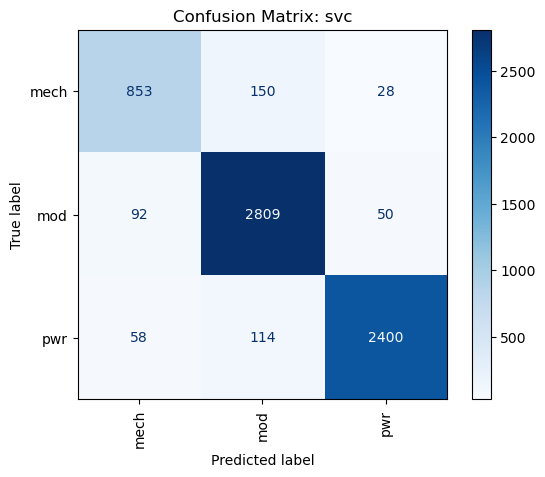

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

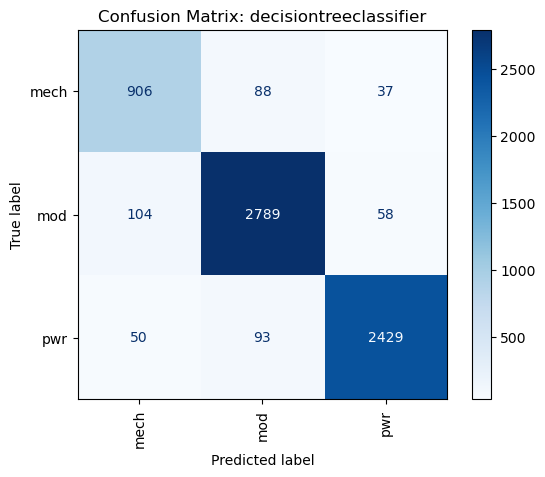

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

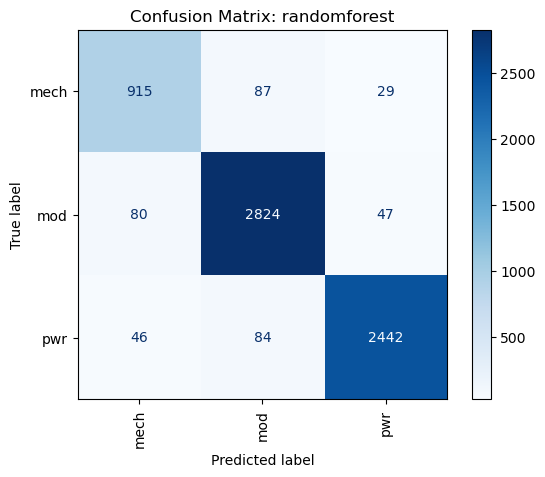

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

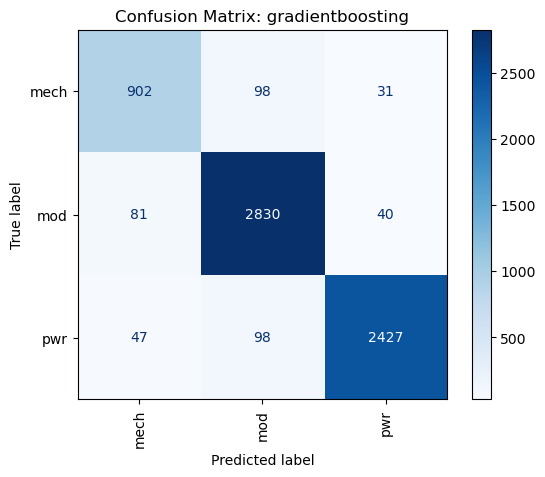


Model Performance:

                        train score  test score  average fit time  precision  \
model                                                                          
knn                        0.979203    0.935154          0.262045   0.935829   
logisticregression         0.888758    0.892432          3.184553   0.893058   
svc                        0.934798    0.924931          2.084760   0.925440   
decisiontreeclassifier     0.961284    0.934391          0.028977   0.934935   
randomforest               0.975018    0.943088          0.335591   0.943407   
gradientboosting           0.964424    0.939731          5.298713   0.940133   

                          recall        f1  \
model                                        
knn                     0.935154  0.935382   
logisticregression      0.892432  0.892570   
svc                     0.924931  0.924859   
decisiontreeclassifier  0.934391  0.934599   
randomforest            0.943088  0.943179   
gradientboosting

In [15]:
# Train + Evaluate models

results = []

for name, (model, params) in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    best_model = grid_search.best_estimator_
    
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    y_pred = best_model.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append([name, train_score, test_score, fit_time, precision, recall, f1, best_model])
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# Create results DataFrame
results_df = pd.DataFrame(
    results,
    columns=['model', 'train score', 'test score', 'average fit time', 'precision', 'recall', 'f1', 'best_estimator']
).set_index('model')

print("\nModel Performance:\n")
print(results_df)

# ---------------------------
# 4. Rank models and select top 3
# ---------------------------
top_models = results_df.sort_values(by=['f1', 'test score'], ascending=False)
best_3 = top_models.head(3)
print("\nTop 3 Models:\n")
print(best_3)

# ---------------------------
# 5. Build VotingClassifier ensemble
# ---------------------------
best_estimators = [(name, best_3.loc[name, 'best_estimator']) for name in best_3.index]

voting_clf = VotingClassifier(estimators=best_estimators, voting='soft')
voting_clf.fit(X_train, y_train)

voting_score = voting_clf.score(X_test, y_test)
print(f"\nVoting Ensemble Test Accuracy: {voting_score:.4f}")

The best model selected was Random Forest. The model achieved a train score of 97.5% and a test score of 94.3%, with an average fit time of approximately 0.34 seconds. In this use case, precision is the most important metric, as it represents the ratio of TP/(TP + FP), meaning we want to minimize false positives. Gradient Boosting not only provides strong precision but also performs consistently across recall and F1-score, making it the best overall model for this dataset.

### Using Best Model Predict Product Type for Unlabeled Data

In [17]:
best_model = grid_search.best_estimator_

# Apply the best model to predict on the unlabelled data
unlab1 = unlab.drop(['type'], axis=1)

# Use the best model for predictions
preds = best_model.predict(unlab1)

# Add predictions and original 'TOP_PID' to the DataFrame
unlab1['Predicted'] = preds
unlab1['TOP_PID'] = unlab['TOP_PID']



/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Create One File To predict Weights

In [18]:
# Rearrange unlab1 to combine with lab

unlab2 = unlab1.rename(columns = {'Predicted' : 'type'})


unlab2 = unlab2[['TOP_PID'] + [col for col in unlab2.columns if col != 'TOP_PID']]
#unlab2 = unlab2.set_index('TOP_PID')

# Get list of all columns
cols = unlab2.columns.tolist()

# Remove 'total_comp' from its current position
cols.remove('total_comp')

# Insert it at position 23 (which is the 24th column)
cols.insert(24, 'total_comp')

# Reorder the DataFrame
unlab2 = unlab2[cols]

# Assign a numerical value to the different types to match the formatting on lab data
unlab2['type'] = unlab2['type'].map({0: 'mech', 1: 'mod', 2: 'pwr'})

# Add labeled and unlabeled data together
combined = pd.concat([lab, unlab2], ignore_index=False)

# Bring weight back into calculation

combined1 = combined.set_index('TOP_PID')
df1 = df.set_index('TOP_PID')


wght = combined1.merge(
    df1[['NET_WEIGHT_KG']],
    left_index=True,
    right_index=True,
    how='left'
)

# Convert type data back to numerical values
wght['type'] = wght['type'].map({'mech' : 0, 'mod' : 1, 'pwr' : 2})

#### Determine Best Model and Hyperparameters to Predict Weight Value

In [19]:
# Split data into labeled and unlabeled

wghtlab = wght[wght['NET_WEIGHT_KG'].notna()]   # rows where 'type' is NOT null
wghtunlab = wght[wght['NET_WEIGHT_KG'].isna()]  # rows where 'type' IS null

wghtlab = wghtlab[wghtlab['NET_WEIGHT_KG'] < 20].copy()

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(wghtlab.drop(['NET_WEIGHT_KG'], axis = 1), 
                                                    wghtlab['NET_WEIGHT_KG'], random_state = 42)

print(wghtlab.shape)

(7815, 25)


Based on initial testing, outliers were preventing the model from having a RMSE below 44, which was no better then just predicting a value using the mean and standard deviation. It was determined that limiting the labeled weight data to products with less then 20 kg weight created a better model.

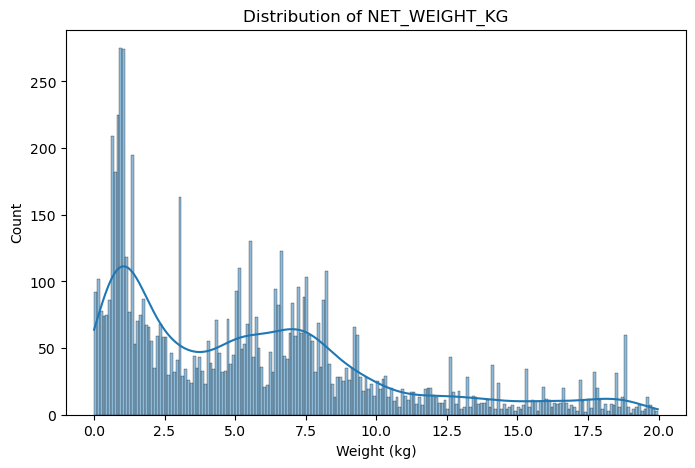

In [20]:
# Distribution of product weight

plt.figure(figsize=(8,5))
sns.histplot(wghtlab['NET_WEIGHT_KG'], bins=200, kde=True)
plt.title("Distribution of NET_WEIGHT_KG")
plt.xlabel("Weight (kg)")
plt.ylabel("Count")
plt.show()

### Create Model to Predict Weight

In [21]:
# Select only numeric columns
X_num = X_train.select_dtypes(include='number')

# Compute correlation with target
corrs = X_num.corrwith(y_train)

# Sort by absolute value
corrs_sorted = corrs.abs().sort_values(ascending=False)
print(corrs_sorted)

mech                                             0.551878
29_27-Connector-Header-Terminal                  0.504154
35-Battery                                       0.419646
IC                                               0.415608
total_comp                                       0.393518
pack                                             0.369577
psu                                              0.330732
elec                                             0.311827
07-RF Equipment                                  0.245051
28-Printed Circuit Board                         0.225508
kit                                              0.211732
06-Audio Equipment                               0.135590
33-Fan-Blower                                    0.128594
43-Video Equipment - Display                     0.108522
cable                                            0.099210
optical                                          0.056578
74-ODM or OEM Assembly                           0.051437
43-Video Equip

After checking for correlation, it was determined to only use features that had a correlation > 0.3

In [31]:
# Build model pipeline and test models to determine model that will produce the lowest RMSE

# 1. Select top features
top_features = ['mech', '29_27-Connector-Header-Terminal', '35-Battery', 
                'IC', 'total_comp', 'pack', 'psu', 'elec']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# 2. Pipeline (scaling)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())   
])

# 3. Wrap with TransformedTargetRegressor (log-transform)
model = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

# 4. GridSearchCV parameter grid
param_grid = [
    # Ridge & Lasso
    {
        'regressor__regressor': [Ridge(), Lasso()],
        'regressor__regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    # KNN
    {
        'regressor__regressor': [KNeighborsRegressor()],
        'regressor__regressor__n_neighbors': [3, 5, 7, 9, 11],
        'regressor__regressor__weights': ['uniform', 'distance']
    },
    # SVR
    {
        'regressor__regressor': [SVR()],
        'regressor__regressor__kernel': ['linear', 'rbf'],
        'regressor__regressor__C': [0.1, 1, 10],
        'regressor__regressor__epsilon': [0.01, 0.1, 1.0]
    },
    # Random Forest
    {
        'regressor__regressor': [RandomForestRegressor()],
        'regressor__regressor__n_estimators': [100, 200],
        'regressor__regressor__max_depth': [None, 5, 10],
        'regressor__regressor__min_samples_split': [2, 5]
    },
    # Gradient Boosting
    {
        'regressor__regressor': [GradientBoostingRegressor()],
        'regressor__regressor__learning_rate': [0.01, 0.1],
        'regressor__regressor__n_estimators': [100, 200],
        'regressor__regressor__max_depth': [3, 5]
    }
]


# 5. Run GridSearchCV
gridcv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

gridcv.fit(X_train_top, y_train)

# 6. Predict and evaluate
y_pred = gridcv.predict(X_test_top)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)
print("Best parameters:", gridcv.best_params_)
print("Best estimator:", gridcv.best_estimator_)



RMSE: 1.9114627700619584
Best parameters: {'regressor__regressor': RandomForestRegressor(), 'regressor__regressor__max_depth': None, 'regressor__regressor__min_samples_split': 2, 'regressor__regressor__n_estimators': 200}
Best estimator: TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('regressor',
                                                      RandomForestRegressor(n_estimators=200))]))


In [33]:
# Create DummyRegressor (baseline model)
dummy = DummyRegressor(strategy="mean")  # predicts mean of training set
dummy.fit(X_train_top, y_train)

# Predict with dummy
y_dummy_pred = dummy.predict(X_test_top)

# Evaluate dummy
dummy_rmse = np.sqrt(mean_squared_error(y_test, y_dummy_pred))
print("Dummy RMSE (mean baseline):", dummy_rmse)

Dummy RMSE (mean baseline): 4.7838504173256045


In [34]:
# Check mean, standard deviation and R^2 of y_test to compare against RMSE value

print("y_train mean value:", y_train.mean())
print("y_train standard deviation:", y_train.std())

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

y_train mean value: 5.69190250810442
y_train standard deviation: 4.784535410364625
R^2: 0.8401048338447903


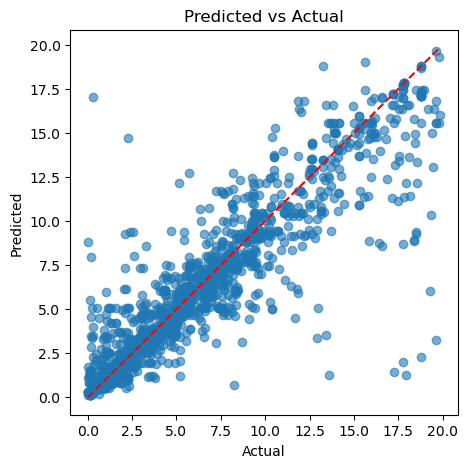

In [35]:
# Compare actual vs predicted data

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

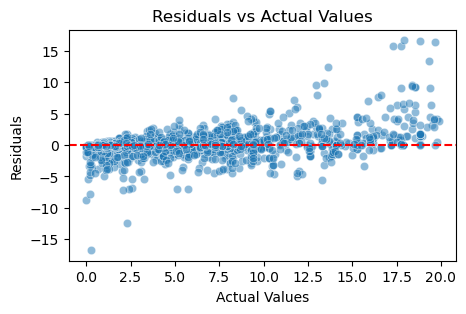

In [36]:
# Compare residuals vs actuals

residuals = y_test - y_pred

plt.figure(figsize=(5, 3))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Values")
plt.show()

The best model identified was a Random Forests with n_estimators = 200, max depth = none and min samlple split = 2. The RMSE was 1.91 which was suppier to just picking the mean and using the standard deviation of the dataset which would have been 5.69 and 4.78 accordingly. The R^2 value was 0.84, which is close to 1 which is considered perfect.

### Predict missing data

In [37]:
# Predict missing data and join back with original data
wghtunlab1 = wghtunlab.drop(['NET_WEIGHT_KG'], axis=1)

# Select top features
top_features = ['mech', '29_27-Connector-Header-Terminal', '35-Battery', 'IC', 'total_comp', 'pack', 'psu', 'elec']
wghtunlab2 = wghtunlab1[top_features]


# Use the best model from GridSearchCV to predict
y_pred = gridcv.best_estimator_.predict(wghtunlab2)

# Add predictions and TOP_PID to the DataFrame
wghtunlab2 = wghtunlab2.copy()  # ensure safe assignment
wghtunlab2['Predicted'] = y_pred


### Create one file to predict power

In [38]:
# Remove unneed features

top_features = ['mech', '29_27-Connector-Header-Terminal', '35-Battery', 'IC', 'total_comp', 'pack', 'psu', 'elec', 'NET_WEIGHT_KG', 'type']
wghtlab1 = wghtlab[top_features]

wghtunlab3 = wghtunlab2.rename(columns = {'Predicted' : 'NET_WEIGHT_KG'})
wghtunlab3['type'] = wghtunlab['type']

# Add labeled and unlabeled data together

combined = pd.concat([wghtlab1, wghtunlab3], ignore_index=False)


In [39]:
# Bring power back into calculation

combined.index = combined.index.astype(str)
df1.index = df1.index.astype(str)

df1 = df.set_index('TOP_PID')

pwr = combined.merge(
    df1[['PROD_PWR_W', 'POWER_TYPE']],
    left_index=True,
    right_index=True,
    how='left'
)

pwr1 = pwr[pwr['type'] == 2]

In [40]:
# Split data into labeled and unlabeled

pwrlab = pwr1[pwr1['POWER_TYPE'] == 'Product Power']   # rows where 'type' is NOT null
pwrunlab = pwr1[pwr1['POWER_TYPE'].isin(['Product Family Power','BU Power','Average Power']) | (pwr['POWER_TYPE'].isna())]  # rows where 'type' IS null

/var/folders/s8/46tslbx12qs9ztmh7gmj3nkm0000gn/T/ipykernel_35345/2878884904.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pwrunlab = pwr1[pwr1['POWER_TYPE'].isin(['Product Family Power','BU Power','Average Power']) | (pwr['POWER_TYPE'].isna())]  # rows where 'type' IS null


In [41]:
print(pwrlab.shape)
print(pwrunlab.shape)

(6311, 12)
(2849, 12)


### Create Model and Hyperparameters to Predict Power

In [42]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pwrlab.drop(['PROD_PWR_W','POWER_TYPE', 'type'], axis=1), 
    pwrlab['PROD_PWR_W'], 
    random_state=42
)

In [43]:
X_num = X_train.select_dtypes(include='number')

# Compute correlation with target
corrs = X_num.corrwith(y_train)

# Sort by absolute value
corrs_sorted = corrs.abs().sort_values(ascending=False)
print(corrs_sorted)

NET_WEIGHT_KG                      0.519645
mech                               0.444756
29_27-Connector-Header-Terminal    0.386497
IC                                 0.313013
total_comp                         0.303746
pack                               0.268570
psu                                0.255196
elec                               0.239917
35-Battery                         0.230843
dtype: float64


In [44]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pwrlab.drop(['PROD_PWR_W','POWER_TYPE', 'type'], axis=1), 
    pwrlab['PROD_PWR_W'], 
    random_state=42
)

# Pipeline: scaler + regressor placeholder
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge()) 
])

# Wrap with log-transform to prevent negative predictions
model = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

# GridSearchCV parameters for Ridge, Lasso, KNN
param_grid = [
    # Ridge Regression
    {
        'regressor__regressor': [Ridge()],
        'regressor__regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    # Lasso Regression
    {
        'regressor__regressor': [Lasso(max_iter=50000)],
        'regressor__regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
    },
    # KNN Regressor
    {
        'regressor__regressor': [KNeighborsRegressor()],
        'regressor__regressor__n_neighbors': [3, 5, 7, 9, 11],
        'regressor__regressor__weights': ['uniform', 'distance']
    }
]

gridcvpwr = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the model
gridcvpwr.fit(X_train, y_train)

# Predict and evaluate
y_pred = gridcvpwr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Best parameters:", gridcv.best_params_)

RMSE: 116.49746887575486
Best parameters: {'regressor__regressor': RandomForestRegressor(), 'regressor__regressor__max_depth': None, 'regressor__regressor__min_samples_split': 2, 'regressor__regressor__n_estimators': 200}


In [45]:
# Dummy regressor to set baseline

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_dummy))

print("RMSE (dummy baseline):", rmse_dummy)

RMSE (dummy baseline): 241.43071303271506


In [46]:
# Check mean, standard deviation and R^2 of y_test to compare against RMSE value

print("y_train mean value:", y_train.mean())
print("y_train standard deviation:", y_train.std())

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

y_train mean value: 129.10751320515533
y_train standard deviation: 242.71258799463612
R^2: 0.7671639950971424


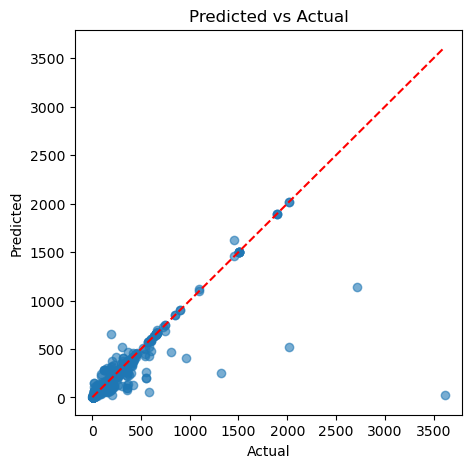

In [47]:
# Plot predicted value vs actual

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

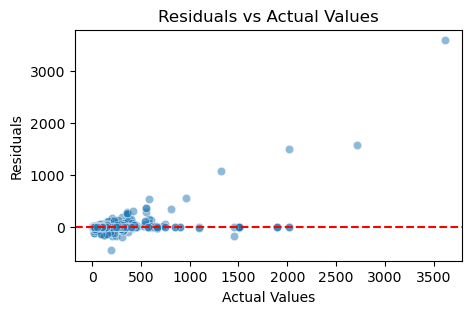

In [48]:
# Residuals vs actuals

residuals = y_test - y_pred

plt.figure(figsize=(5, 3))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Values")
plt.show()

The best model identified was a Random Forest with n_estimators = 200, max depth = None. The RMSE was 116.50 which was supperier to just picking the mean and using the standard deviation of the dataset which would have been 129.10 and 241.43 accordingly. The R^2 value was 0.767, which is close to 1 which is considered perfect.


### Predict missing data

In [49]:
# Predict missing values for unlabeled data

pwrunlab1 = pwrunlab.drop(['PROD_PWR_W', 'POWER_TYPE', 'type'], axis = 1)

best_model = gridcvpwr.best_estimator_

preds = best_model.predict(pwrunlab1)

# Add missing data to file for review

pwrunlab2 = pwrunlab1
pwrunlab2['Predicted'] = preds
pwrunlab2['PROD_PWR_W'] = pwrunlab['PROD_PWR_W']

# Print to file

pwrunlab2.to_csv('pwrun.csv', index=True)